In [1]:
import os
from pysmiles import read_smiles
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch_geometric
import torch
from torch import nn
from torch_geometric.data import Dataset, DataLoader
from torchvision import models
import deepchem as dc

print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.7.1+cu110
Cuda available: True
Torch geometric version: 1.7.2


# Dataset

In [2]:
class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        #self.data = self.data.iloc[29628:]
        #print(self.data.iloc[-1])
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            f = featurizer.featurize(mol["SMILES"])
            data = f[0].to_pyg_graph()
            data.smiles = mol["SMILES"]
            if not self.test:
                data.y = self._get_label(mol["target"])
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))
            

    def _get_label(self, label):
        if not self.test:
            label = np.asarray([label])
            return torch.tensor(label, dtype=torch.float32)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

In [4]:
train_dataset = MoleculeDataset(root="../data/", filename="new_train.csv")
train_dataset  = train_dataset.shuffle()

In [5]:
int(len(train_dataset)*0.8)

24275

In [7]:
train_dataloader = DataLoader(train_dataset[:24275], batch_size=BATCH_SIZE, num_workers=0, shuffle=True)
val_dataloader = DataLoader(train_dataset[24275:], batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

In [8]:
sample_batch = next(iter(train_dataloader))
sample_batch

Batch(batch=[1567], edge_attr=[3362, 11], edge_index=[2, 3362], ptr=[65], smiles=[64], x=[1567, 30], y=[64])

# Hyperparameters

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 200
#num_layers = 1
#dropout_rate = 0.1
embedding_size = 128
learning_rate = 1e-4
vision_pretrain = True
save_path = "./models/sage/best_model.pt"

# Model

In [9]:
from torch_geometric.nn import SAGEConv, global_max_pool

import torch
import torch.nn.functional as F


class GraphSAGE(nn.Module):
    def __init__(self, dim_features, dim_target, config):
        super().__init__()

        num_layers = config['num_layers']
        dim_embedding = config['dim_embedding']
        self.aggregation = config['aggregation']  # can be mean or max

        if self.aggregation == 'max':
            self.fc_max = nn.Linear(dim_embedding, dim_embedding)

        self.layers = nn.ModuleList([])
        for i in range(num_layers):
            dim_input = dim_features if i == 0 else dim_embedding

            conv = SAGEConv(dim_input, dim_embedding)
            # Overwrite aggregation method (default is set to mean
            conv.aggr = self.aggregation

            self.layers.append(conv)

        # For graph classification
        self.fc1 = nn.Linear(num_layers * dim_embedding, dim_embedding)
        self.fc2 = nn.Linear(dim_embedding, dim_target)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x_all = []

        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            if self.aggregation == 'max':
                x = torch.relu(self.fc_max(x))
            x_all.append(x)

        x = torch.cat(x_all, dim=1)
        x = global_max_pool(x, batch)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
dim_features = train_dataset.num_features
dim_target = 1
config = {'num_layers': 3, 'dim_embedding': 128, 'aggregation':'max'}
model = GraphSAGE(dim_features, dim_target, config)
model = model.to(device)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
model

Number of parameters:  139521


GraphSAGE(
  (fc_max): Linear(in_features=128, out_features=128, bias=True)
  (layers): ModuleList(
    (0): SAGEConv(30, 128)
    (1): SAGEConv(128, 128)
    (2): SAGEConv(128, 128)
  )
  (fc1): Linear(in_features=384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

# Train

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()

In [12]:
def train_step(batch_item, epoch, batch, training):
    #x = batch_item['x'].float()
    #edge_index = batch_item['edge_index']
    #batch = batch_item['batch']
    label = batch_item['y']

    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(batch_item)
            #print(output.shape)
            #print(label.shape)
            loss = criterion(output.view(-1), label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(batch_item)
            #print(output.shape)
            #print(label.shape)            
            loss = criterion(output.view(-1), label)
            
        return loss

In [13]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_item.to(device)
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_item.to(device)
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model.state_dict(), save_path)

380it [00:10, 37.49it/s, Epoch=1, Loss=0.233310, Total Loss=0.294400]
95it [00:01, 55.08it/s, Epoch=1, Val Loss=0.204328, Total Val Loss=0.266031]
380it [00:08, 42.83it/s, Epoch=2, Loss=0.218151, Total Loss=0.249296]
95it [00:01, 65.32it/s, Epoch=2, Val Loss=0.217949, Total Val Loss=0.240808]
380it [00:09, 40.14it/s, Epoch=3, Loss=0.256728, Total Loss=0.226953]
95it [00:01, 60.05it/s, Epoch=3, Val Loss=0.215080, Total Val Loss=0.224735]
380it [00:08, 45.10it/s, Epoch=4, Loss=0.350111, Total Loss=0.212277]
95it [00:01, 64.24it/s, Epoch=4, Val Loss=0.195078, Total Val Loss=0.215784]
380it [00:08, 42.27it/s, Epoch=5, Loss=0.169847, Total Loss=0.203005]
95it [00:01, 48.47it/s, Epoch=5, Val Loss=0.197539, Total Val Loss=0.202190]
380it [00:08, 44.88it/s, Epoch=6, Loss=0.216833, Total Loss=0.195042]
95it [00:01, 65.33it/s, Epoch=6, Val Loss=0.194557, Total Val Loss=0.199444]
380it [00:08, 44.91it/s, Epoch=7, Loss=0.198763, Total Loss=0.191436]
95it [00:01, 63.31it/s, Epoch=7, Val Loss=0.2281

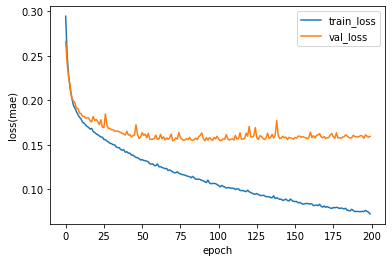

In [14]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

# Load

In [15]:
loaded_model = GraphSAGE(dim_features, dim_target, config)
loaded_model.load_state_dict(torch.load(save_path))

#model.eval()

<All keys matched successfully>

In [16]:
for param in loaded_model.parameters():
    print(param)
    break

Parameter containing:
tensor([[-0.0938, -0.0155, -0.0675,  ..., -0.0464, -0.0756, -0.0692],
        [ 0.0307, -0.0758, -0.0135,  ..., -0.0044,  0.0205, -0.0124],
        [-0.0746,  0.0075, -0.0420,  ...,  0.0946,  0.0084, -0.0159],
        ...,
        [-0.0405, -0.0818,  0.0133,  ..., -0.0894, -0.0912,  0.0730],
        [-0.0903, -0.0517,  0.1414,  ...,  0.0946, -0.0051,  0.0728],
        [-0.0846,  0.0626,  0.0271,  ..., -0.0529, -0.0608,  0.0351]],
       requires_grad=True)


# Test

In [17]:
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [18]:
test

,uid,SMILES
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)...
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(...
3,test_3,CCCn1c(=O)c2ccccc2n2c(SCC(=O)NC(Cc3ccccc3)c3cc...
4,test_4,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cn...
...,...,...
597,test_597,N#Cc1c(-n2c3ccccc3c3ccccc32)c(-n2c3ccccc3c3ccc...
598,test_598,CC1(C)c2ccccc2N(c2ccc(-c3cc(-c4ccc(N5c6ccccc6C...
599,test_599,Cc1nc(-c2ccc(N3c4ccccc4C(C)(C)c4ccccc43)cc2)cc...
600,test_600,c1ccc2c(c1)Oc1ccccc1N2c1ccc(-c2nc3ccccc3s2)cc1


In [19]:
test_dataset = MoleculeDataset(root="../data/", filename="test.csv", test=True)

In [20]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
test_dataloader

In [21]:
def predict(dataset):
    loaded_model.to(device)
    loaded_model.eval()
    result = []
    for batch_item in dataset:
        batch_item.to(device)
        with torch.no_grad():
            output = loaded_model(batch_item)
        output = output[:, 0]
        output = output.cpu().numpy()
        result.extend(output)
        
    return result

In [22]:
pred = predict(test_dataloader)
submission['ST1_GAP(eV)'] = pred
submission

,uid,ST1_GAP(eV)
0,test_0,0.799336
1,test_1,1.827644
2,test_2,1.284345
3,test_3,0.531842
4,test_4,0.758733
...,...,...
597,test_597,0.090313
598,test_598,0.136329
599,test_599,0.216002
600,test_600,0.379241


In [23]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uid          602 non-null    object 
 1   ST1_GAP(eV)  602 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.5+ KB


In [24]:
submission.to_csv('dacon_baseline.csv', index=False)

In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
    'dacon_baseline.csv', 
    '59375e1f3b2f6e39215d683eaee1a165fb30ef348d1da88be153f64c17dfe759', 
    '235789', 
    'melona', 
    'sage_2'
)